Step 1: Load and Inspect the Data

In [82]:
import pandas as pd 

df = pd.read_csv('UsArrests.csv', index_col=0)
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB
None
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000


Step 2: Exploratory Data Analysis 

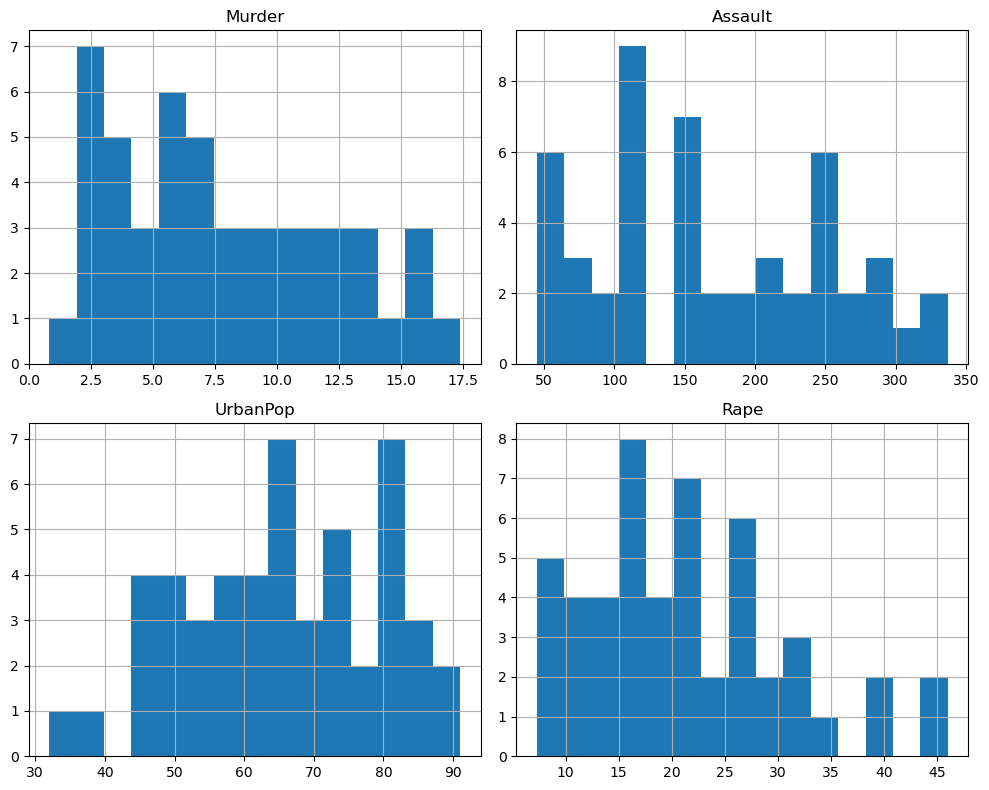

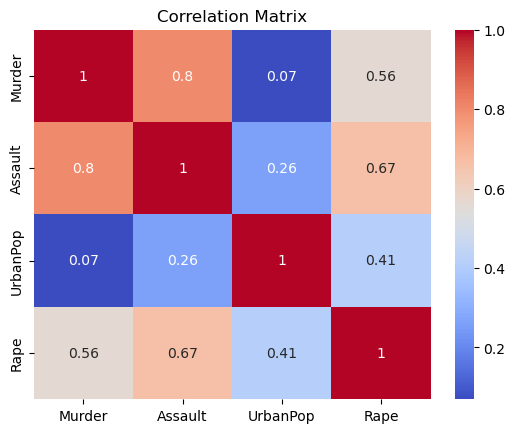

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

df.hist(bins=15, figsize=(10, 8))
plt.tight_layout()
plt.show()

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Step 3: Preprocessing for PCA

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

Step 4: PCA Implementation

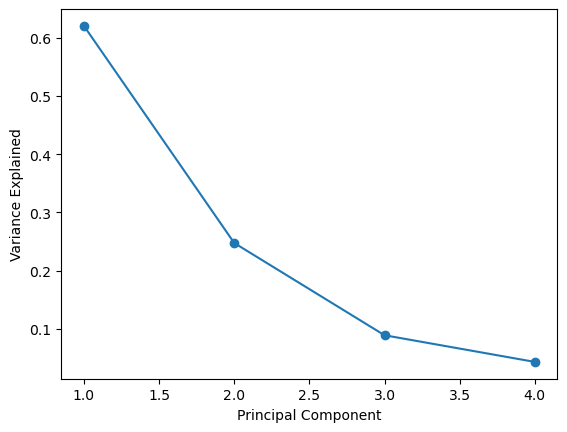

       Murder   Assault  UrbanPop      Rape
PC1  0.535899  0.583184  0.278191  0.543432
PC2  0.418181  0.187986 -0.872806 -0.167319
PC3 -0.341233 -0.268148 -0.378016  0.817778
PC4  0.649228 -0.743407  0.133878  0.089024


In [85]:
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pca.fit_transform(df_scaled)

# Scree plot
plt.plot(range(1, 5), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

pca_df = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(4)])
print(pca_df)

# PCA Scree Plot Interpretation
- PC1 + PC2 = ~87% of the total variance
- This means 2 components are sufficient for visualizing most of the structure in the data
- You can reduce dimensionally from 4D to 2D without much loss

# Principal Component Loadings Interpretations
- PC1 is strongly influenced by Murder, Assault, and Rape. Likely a "Violent Crime Index".
- PC2 is dominated by UrbanPop ( negative weight), possibly reflecting urbanization vs rural settings.
- PC3 loads heavily on Rape (positive), contrasting it against other crime metrics.
- PC4 has mixed values but not much variance explained, ignore in clustering

Step 5: PCA Scatter Plot

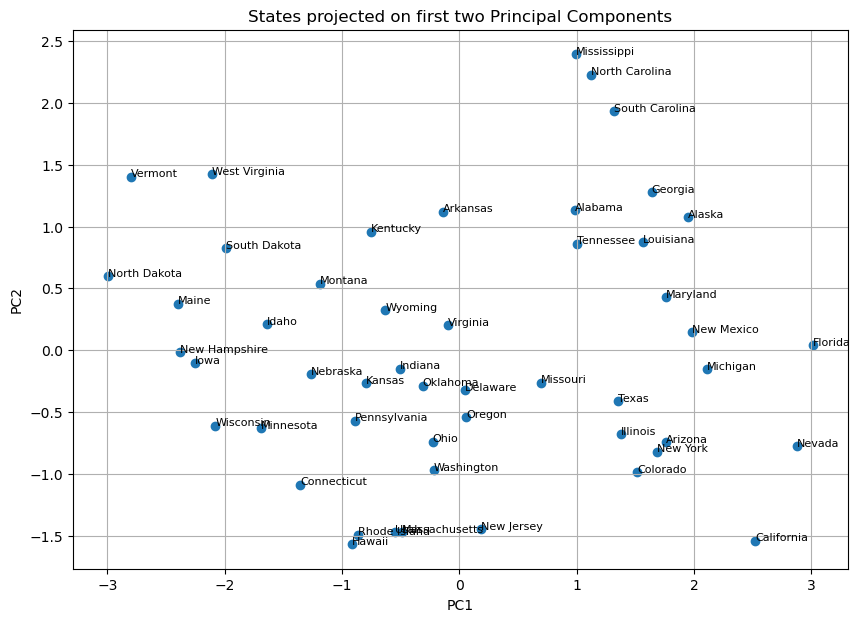

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(pca_data [:, 0], pca_data[:, 1])
for i, state in enumerate(df.index):
    plt.text(pca_data[i, 0], pca_data[i, 1], state, fontsize=8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("States projected on first two Principal Components")
plt.grid()
plt.show()

# PCA Interpretation of the Plot

Oberservations:
- Right-side states (positive PC1) like California, Florida, Nevada, are high in violent crime rates (PC1 is dominated by Murder, Assult and Rape)

- Top-side States (positive PC2) like Mississippi, North Carolina, South Carolina, are low UrbanPop (since PC2 is dominated negatively by UrbanPop).

- Bottom-left states (negative PC1 & PC2) like Hawaii, Massachusetts, Rhode Island, are likely low crime and highly urban.

Step 6: Clustering Techniques
Technique 1: KMeans

/Users/aashiqebrahim/miniconda3/envs/base_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aashiqebrahim/miniconda3/envs/base_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aashiqebrahim/miniconda3/envs/base_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aashiqebrahim/miniconda3/envs/base_env/lib/python3.8/site-packages/sklearn/

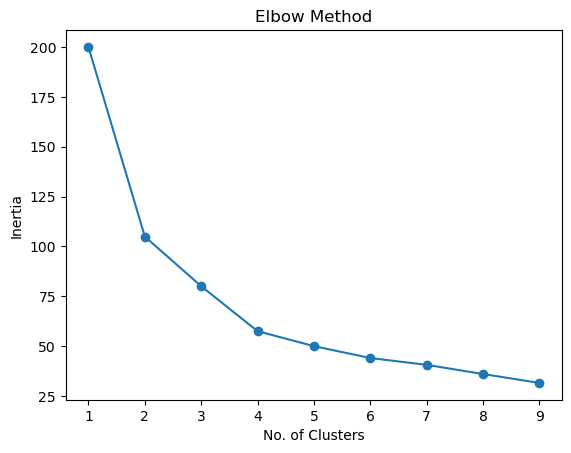

/Users/aashiqebrahim/miniconda3/envs/base_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [87]:
from sklearn.cluster import KMeans

# Try Multiple k-values
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

# Elbow plot
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.show()

# Fit with best K
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Clusters'] = kmeans.fit_predict(df_scaled)

# Elbow Method Interpretation
Observations:
- There's a sharp drop in inertia from k=1 to k=3, and a slower decline after.
- The "elbow" appears clearly at k = 3

Technique 2: Hierarchical Clustering

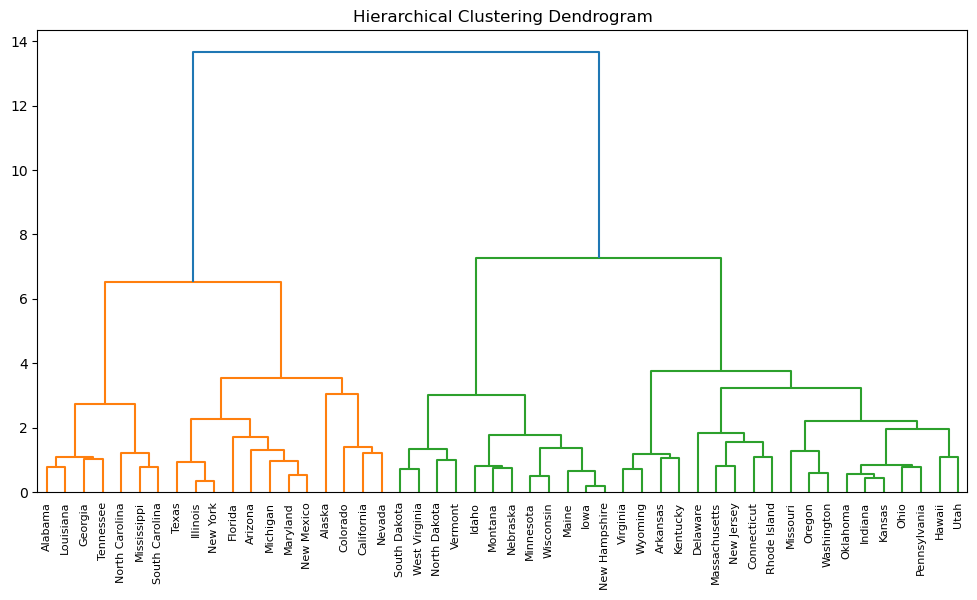

In [88]:
import scipy.cluster.hierarchy as sch 
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(df_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

# Hierarchical Dendrogram Interpretation

Key Observations:
- The Largest vertical jump occurs when the dataset merges into 2 or 3 major clusters at the top (between ~6 and ~13 on the y-axis)

- A natural cutoff for number of clusters is around 3, which aligns well with the KMeans Elbow Method

Assigning Clusters

In [89]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df['Hierarchical_Cluster'] = hc.fit_predict(df_scaled)

/Users/aashiqebrahim/miniconda3/envs/base_env/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Step 7: Cluster Analysis

/Users/aashiqebrahim/miniconda3/envs/base_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans Cluster Means:
                    Murder  Assault   UrbanPop      Rape  KMeans_Clusters  \
KMeans_Cluster                                                             
0                5.656250  138.875  73.875000  18.78125              0.0   
1               12.165000  255.250  68.400000  29.16500              1.0   
2                3.971429   86.500  51.928571  12.70000              2.0   

                Hierarchical_Cluster  
KMeans_Cluster                        
0                           1.000000  
1                           0.050000  
2                           1.857143  

Hierarchical Cluster Means:
                          Murder     Assault   UrbanPop       Rape  \
Hierarchical_Cluster                                                
0                     12.331579  259.315789  68.315789  29.215789   
1                      6.210526  142.052632  71.263158  19.184211   
2                      3.091667   76.000000  52.083333  11.833333   

                      KMe

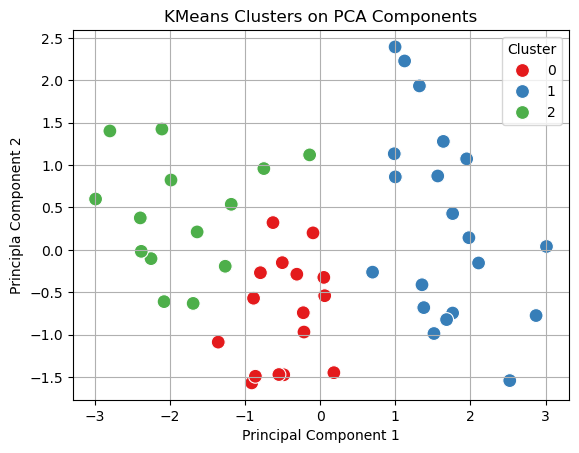

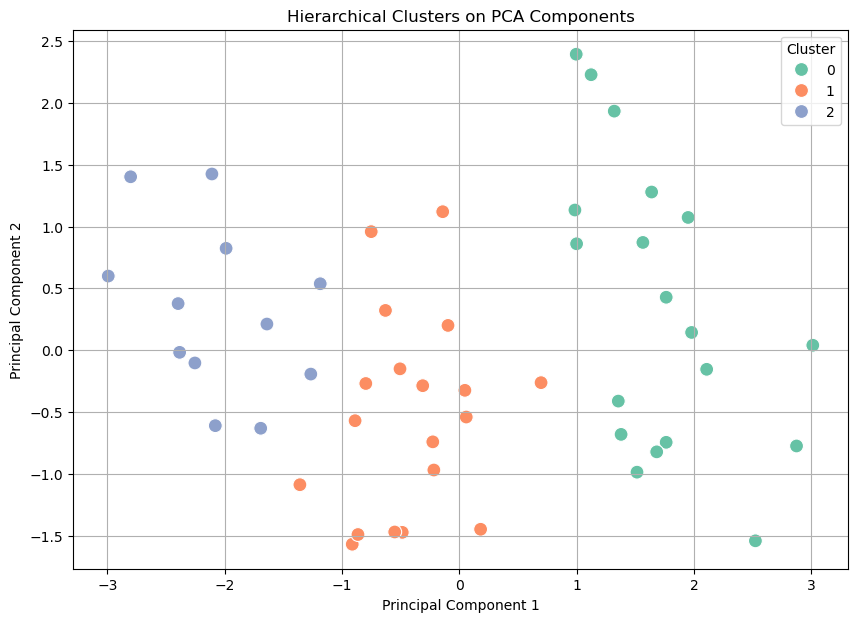

In [90]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled) 

print("KMeans Cluster Means:\n", df.groupby('KMeans_Cluster').mean())
print("\nHierarchical Cluster Means:\n", df.groupby('Hierarchical_Cluster').mean())

# Visualize Clusters
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['KMeans_Cluster'], palette='Set1', s=100)
plt.title("KMeans Clusters on PCA Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principla Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1],
                hue=df['Hierarchical_Cluster'], palette='Set2', s=100)
plt.title("Hierarchical Clusters on PCA Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# Conclusion

This analysis explored the USArrests dataset using Principal Component Analysis (PCA) and two clustering techniques-KMeans and Hierarchical Agglomerative Clustering. PCA revealed that the first two principal components accounted for approximately 87% of the variance in the data, allowing for effective dimensionally reduction and visualization. The loadings indicated that violent crime variables (Muder, Assault, Rape) contributed heavily to the first component, while UrbanPop dominated the second, separating states by crime intensity and urbanization levels. Clustering based on the PCA-transformed data showed that both KMeans and Hierarchical Clustering identified three distinct groupings of states. These clusters broadly aligned with known socio-geographical patterns, such as higher crime, less urban states versus lower crime, more urbanized ones. While there were minor differences in cluster assigments between the two methods, the results overall validated PCA as a strong preprocessing step for uncovering latent structure in the dataset. This project demonstates the power of unsupervised learning techniques in revealing meaningful patterns in multivariate social data.